In [1]:
# asyncio inside jupyter
!pip install nest-asyncio
import nest_asyncio
nest_asyncio.apply()

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
from LocalHFEvaluator import LocalHFEvaluator

model_path="models/TinyLlama-1.1B-Chat-v1.0"

# async def main():
ht = LocalHFEvaluator(
    model_path, 
    {
        "torch_dtype": torch.bfloat16, 
        # "load_in_4bit": True,
        "device_map": "auto",
        # "use_flash_attention_2": True
    },
    evaluation_method="not-gpt4", 
    context_lengths_min=100,
    context_lengths_max=10_000, 
    context_lengths_num_intervals=20, 
    document_depth_percent_intervals=20)


In [3]:
from tlc.LongLM.modify_utils import modify_method_of_instance
from tlc.LongLM import llama_self_extend_patch
from functools import partial

self_extend_forward = partial(llama_self_extend_patch.self_extend_forward, group_size_1=4, group_size_2=1024)
modify_method_of_instance(ht.model, "LlamaAttention", "forward", self_extend_forward)

In [4]:
ht.start_test()

Token indices sequence length is longer than the specified maximum sequence length for this model (5502 > 2048). Running this sequence through the model will result in indexing errors




Starting Needle In A Haystack Testing...
- Model: models/TinyLlama-1.1B-Chat-v1.0
- Context Lengths: 20, Min: 100, Max: 10000
- Document Depths: 20, Min: 0%, Max: 100%
- Needle: The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.



-- Test Summary -- 
Duration: 3.9 seconds
Context: 100 tokens
Depth: 0%
Score: 1
Response: <|assistant|>
The best thing to do in San Francisco is to eat an iconic and delicious sandwich (e.g., a sandwich at The Cow Food Truck) and soak up the beautiful views of the Golden Gate Bridge and Alcatraz Islands from Dolores Park on a sunny day. This combination of delicious food and scenic views is sure to bring an unforgettable experience to the city.

-- Test Summary -- 
Duration: 1.2 seconds
Context: 100 tokens
Depth: 5%
Score: 1
Response: <|assistant|>
The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.

-- Test Summary -- 
Duration: 9.9 seconds
Context: 100 tokens
Depth:

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


-- Test Summary -- 
Duration: 6.7 seconds
Context: 2184 tokens
Depth: 0%
Score: 0
Response: <|assistant|>
Ensure that you remember your dreams, say what you feel, and be happy. These regrets are rooted in the desire to make mistakes as a cog in a system, which is unrealistic and a reflection of the flawed concept of making things a priority. The best option for creating a Technology Hub in Silicon Valley lies in attracting the right kind of people, including millionaires and investors who are not focused on startups, nor do they understand the nuances of what it takes to create a successful start-up. Instead, the ultimate objective should be to create a startup hub where nerds and investors can collaborate and grow together, as demonstrated by prestigious universities like Stanford. The article concludes by emphasizing that the ideal solution has to be borne from someone else's experience as they would make the most difference.

-- Test Summary -- 
Duration: 7.3 seconds
Context: 2184 t

KeyboardInterrupt: 

# Visualize

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Path to the directory containing JSON results
folder_path = 'results/TinyLlama-1_1B-Chat-v1_0-SE'  # Replace with your folder path

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}/*.json")

# List to hold the data
data = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        score = json_data.get("score", None)
        # Appending to the list
        data.append({
            "Document Depth": document_depth,
            "Context Length": context_length,
            "Score": score
        })

# Creating a DataFrame
df = pd.DataFrame(data)

print (df.head())
print (f"You have {len(df)} rows")

   Document Depth  Context Length  Score
0             0.0            2705      0
1            58.0            2184      0
2            95.0            1663      1
3            53.0            2184      0
4            16.0            5832      0
You have 240 rows


In [5]:
pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

Context Length,100,621,1142,1663,2184
Document Depth,,,,,
0.0,1.0,1.0,0.0,0.0,0.0
5.0,1.0,0.0,1.0,1.0,0.0
11.0,1.0,1.0,0.0,1.0,0.0
16.0,1.0,0.0,0.0,0.0,0.0
21.0,1.0,0.0,1.0,0.0,0.0


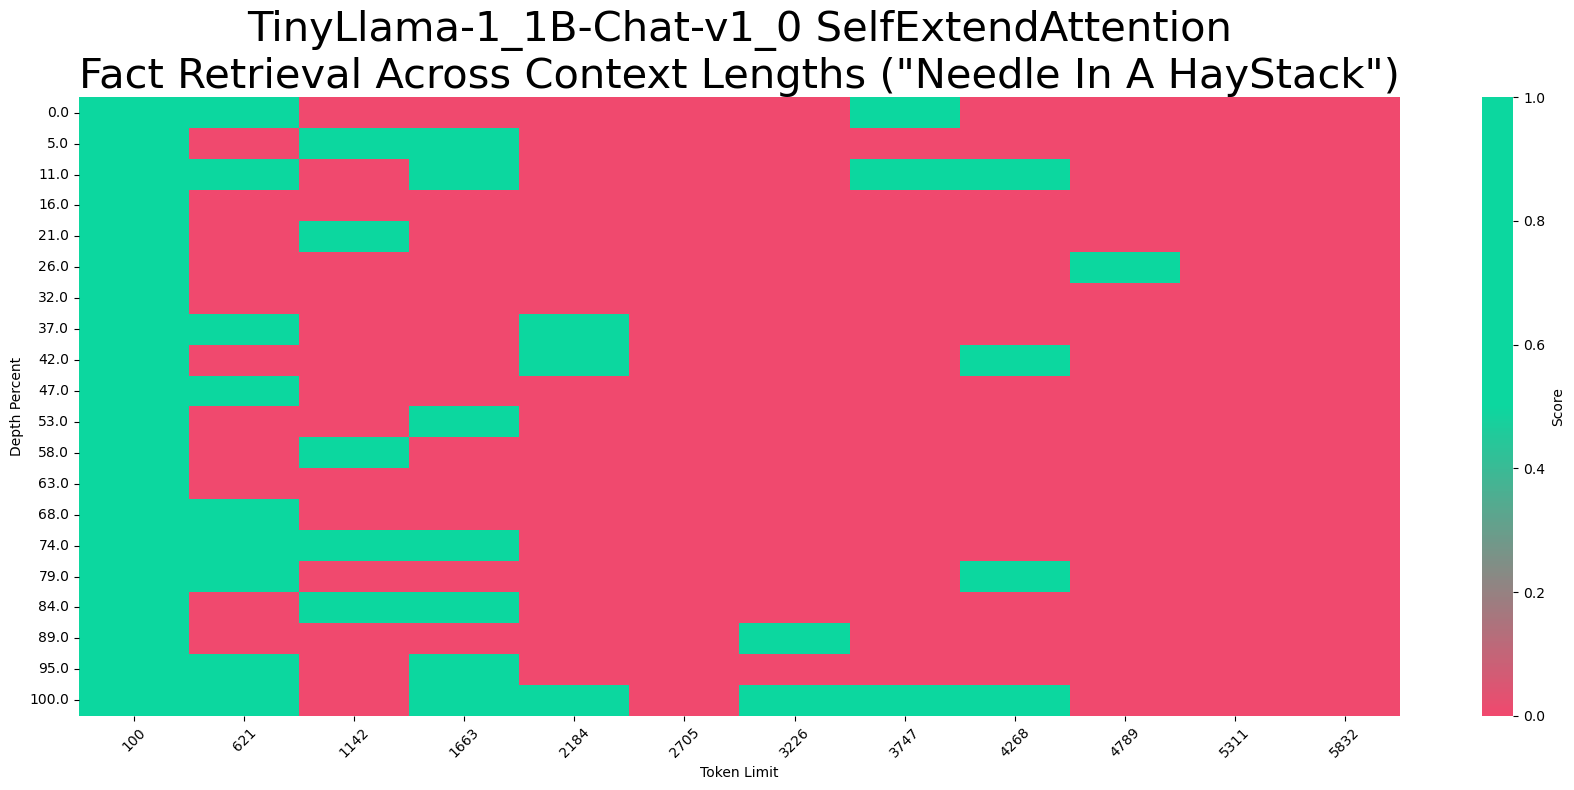

In [7]:
# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#0CD79F", "#0CD79F"])

# Create the heatmap with better aesthetics
plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
sns.heatmap(
    pivot_table,
    # annot=True,
    fmt="g",
    cmap=cmap,
    cbar_kws={'label': 'Score'}
)

# More aesthetics
plt.title(
    f'TinyLlama-1_1B-Chat-v1_0 SelfExtendAttention\nFact Retrieval Across Context Lengths ("Needle In A HayStack")',
    fontsize=30
)  # Adds a title
plt.xlabel('Token Limit')  # X-axis label
plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

plt.savefig('TL_SE.jpg')

# Show the plot
plt.show()

# Sample

In [ ]:
import json

def read_json(file_path):
    f = open(file_path)
    data = json.load(f)
    f.close()
    return data

d=read_json("results/mistral/models_Mistral-7B-Instruct-v0_2_len_37778_depth_0_results.json")

print(json.dumps(d, indent=2))